This file is about evaluating diffrent models to find the best segmentation for our model

In [67]:
from transformers import pipeline
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import evaluation

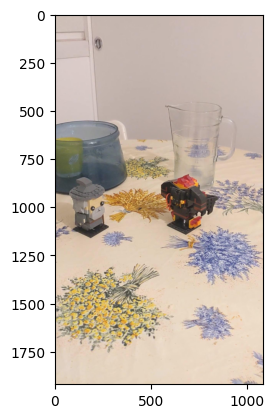

In [68]:
#Load Image
#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/segmentation_input.jpg"
#url = "https://images.squarespace-cdn.com/content/v1/5d00ff1460665300016b8dc9/1560889669316-Y1NYTQY2Q3WL0GLKPNTY/IMG_20180622_134600.jpg"
url = "https://hips.hearstapps.com/hmg-prod/images/small-living-room-ideas-lisa-dawson-66ba2b7398f74.jpeg?crop=1xw:0.9900990099009901xh;center,top&resize=980:*"
#image = Image.open(requests.get(url, stream=True).raw)
img_path = "..\\Image_Segmentation\\labels\\0001_3\\img.png"
image = Image.open(img_path)

plt.imshow(image)
plt.show()

Get prediction masks

In [69]:
#Instance Segmentation
#instance_segmentation = pipeline("image-segmentation", "facebook/mask2former-swin-large-cityscapes-instance", device='cuda')
instance_segmentation = pipeline("image-segmentation", "nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
results = instance_segmentation(image)
print(results)
nb_mask = len(results)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': None, 'label': 'road', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E681536F90>}, {'score': None, 'label': 'sidewalk', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E681FE0250>}, {'score': None, 'label': 'building', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E68122F3D0>}, {'score': None, 'label': 'fence', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E6813ADAD0>}, {'score': None, 'label': 'pole', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E681429C90>}, {'score': None, 'label': 'traffic sign', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E68143AF90>}, {'score': None, 'label': 'vegetation', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E682728690>}, {'score': None, 'label': 'car', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E684E9C950>}, {'score': None, 'label': 'truck', 'mask': <PIL.Image.Image image mode=L size=1080x1920 at 0x1E684F38310>}, {'score': None, 'label

(1920, 1080, 3)


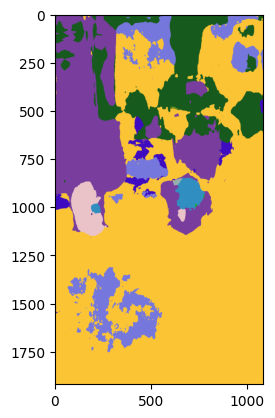

In [70]:
masks = [np.array(results[i]["mask"]) for i in range(nb_mask)]
segmentation_map = evaluation.generate_segmentation_map(masks)

plt.imshow(segmentation_map)

Get ground truth masks

(1920, 1080, 3)
(1920, 1080)
(1920, 1080, 3)


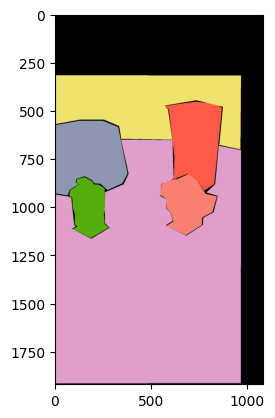

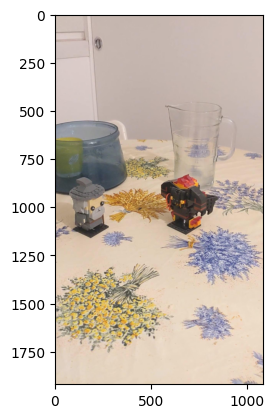

In [ ]:
label_png = "..\\Image_Segmentation\\labels\\0001_3\\label.png" #this is generated by lableme

lbl = np.asarray(Image.open(label_png))
print(np.array(image).shape)
print(lbl.shape)
nb_labels = np.max(np.unique(lbl))
gt_masks = [np.where(lbl == i, 1, 0) for i in range(1,nb_labels+1)]

segmentation_map = evaluation.generate_segmentation_map(gt_masks)


In [72]:
#evaluate the model
ious = evaluation.get_ious_from_masks(masks, gt_masks)

for i in range(len(ious)):
    print(f"the max ious of mask {i} is: {ious[i][1]} with iou = {ious[i][0]}")

the max ious of mask 0 is: 2 with iou = 0.6216789373188294
the max ious of mask 1 is: 2 with iou = 0.022822402191902184
the max ious of mask 2 is: 5 with iou = 0.2138610489071448
the max ious of mask 3 is: 1 with iou = 0.0034744380628235127
the max ious of mask 4 is: 3 with iou = 0.003320472106999886
the max ious of mask 5 is: 0 with iou = 0.0011557549799442518
the max ious of mask 6 is: 2 with iou = 0.09500143020594966
the max ious of mask 7 is: 4 with iou = 0.3228519759438128
the max ious of mask 8 is: 0 with iou = 0.6793720538361453
the max ious of mask 9 is: 1 with iou = 0.018772268803290023
the max ious of mask 10 is: 1 with iou = 0.30351246385737995


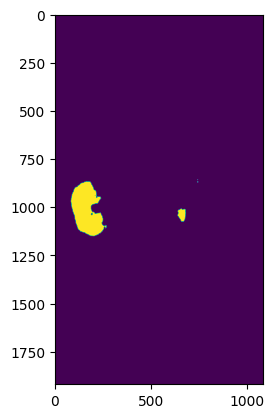

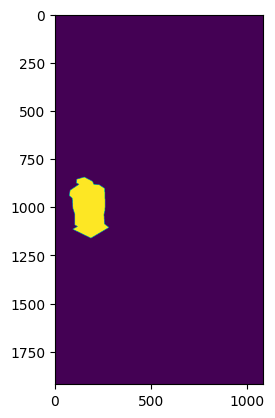

In [73]:
plt.imshow(results[8]["mask"])
plt.show()
plt.imshow(gt_masks[0])

Nvidia segmentation model doesn't seems to work fine

The problem maybe due to the dataset, let's try a model that is trained by coco dataset 

In [74]:
import requests
from PIL import Image
import torch
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on COCO instance segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-coco-instance")

#image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_instance_map = result["segmentation"]

c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


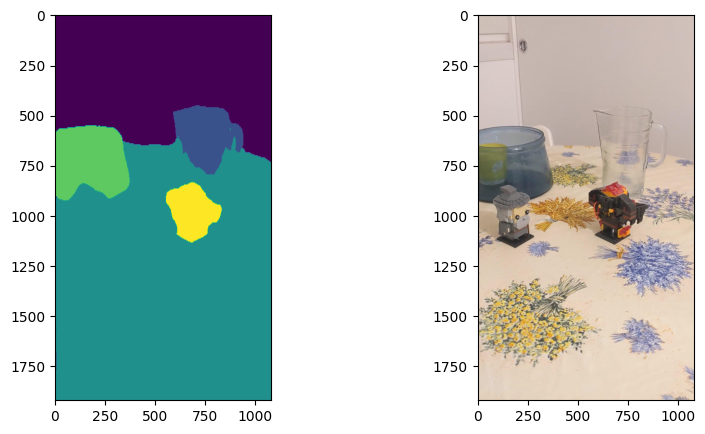

In [75]:
# Create a figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

predicted_array = np.array(predicted_instance_map)
ax[0].imshow(predicted_array)
ax[1].imshow(image)

3
(1920, 1080, 3)


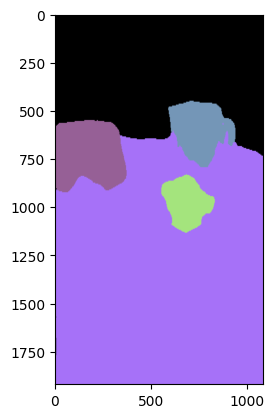

In [76]:
#generate masks
nb_mask = int(np.max(np.unique(predicted_array)))
masks = []
print(nb_mask)
for i in range(nb_mask+1):
    mask = np.where(predicted_array == i, 255, 0)
    masks.append(mask)

segmentation_map = evaluation.generate_segmentation_map(masks)
plt.imshow(segmentation_map)


the max ious of mask 0 is: 3 with iou = 0.6401123858581128
the max ious of mask 1 is: 2 with iou = 0.8034226381764727
the max ious of mask 2 is: 4 with iou = 0.962196831329907
the max ious of mask 3 is: 1 with iou = 0.9229702935551227


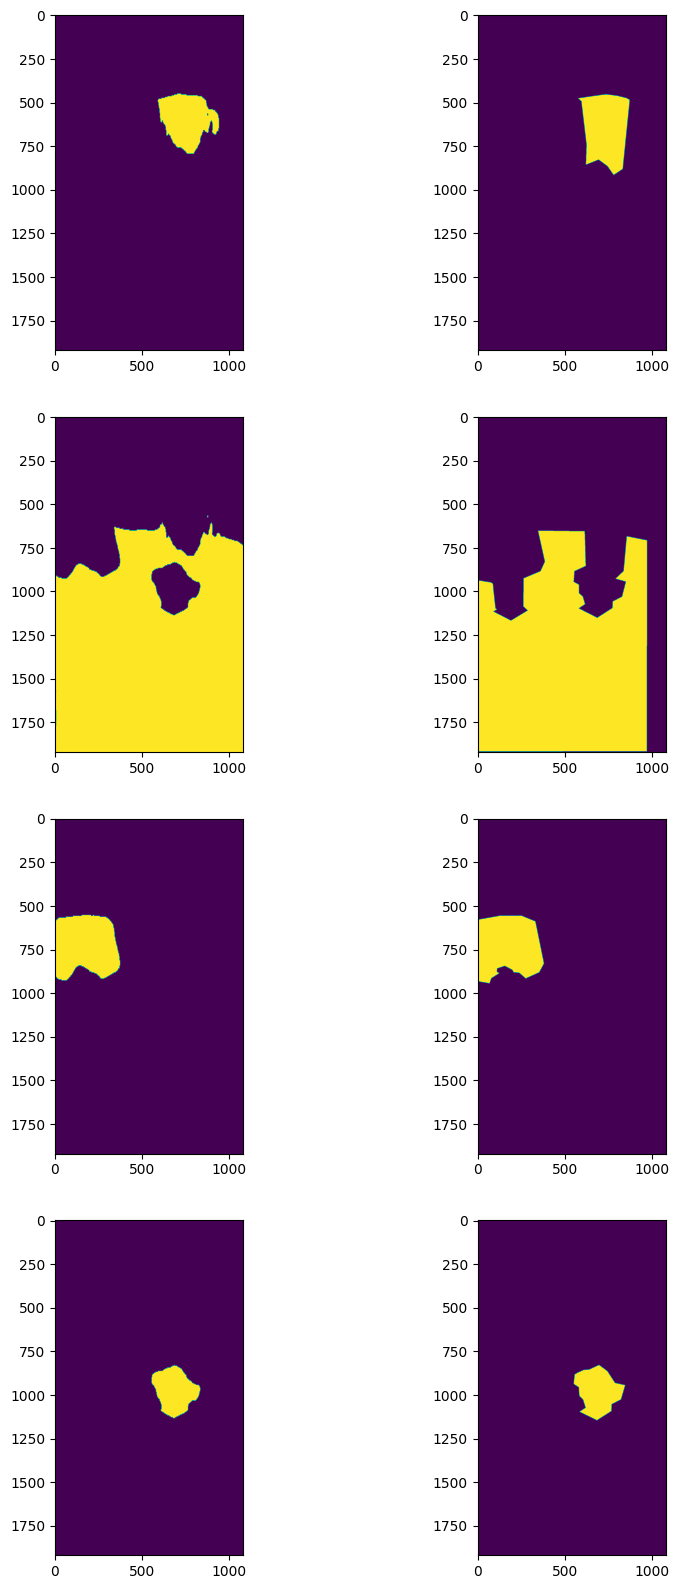

In [84]:
#evaluate the model
ious = evaluation.get_ious_from_masks(masks, gt_masks)

for i in range(len(ious)):
    print(f"the max ious of mask {i} is: {ious[i][1]} with iou = {ious[i][0]}")

fig, ax = plt.subplots(4, 2, figsize=(10, 20))  # 1 row, 2 columns

predicted_array = np.array(predicted_instance_map)
ax[0,0].imshow(masks[0])
ax[0,1].imshow(gt_masks[3])

ax[1,0].imshow(masks[1])
ax[1,1].imshow(gt_masks[2])

ax[2,0].imshow(masks[2])
ax[2,1].imshow(gt_masks[4])

ax[3,0].imshow(masks[3])
ax[3,1].imshow(gt_masks[1])


The true positif seems satisfying. But some objects are missing